## Exploring the bootstrap

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot, poisson

Generate random samples from a Poisson distribution

In [164]:
lam = 2

samp_size_lrg = 2000
samp_size_sml = 20
randseed = 111

np.random.seed(randseed)

sample_sml = poisson.rvs(lam, size=(samp_size_sml,))
sample_lrg = poisson.rvs(lam, size=(samp_size_lrg,))

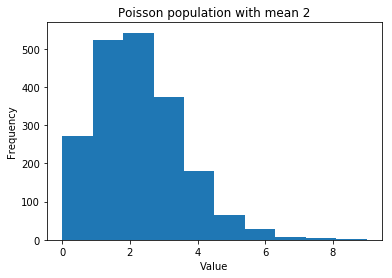

In [165]:
fig_pop, ax_pop = plt.subplots()
ax_pop.hist(sample_lrg)
ax_pop.set_xlabel('Value')
ax_pop.set_ylabel('Frequency')
ax_pop.set_title('Poisson population with mean {}'.format(lam))
plt.show()

Suppose we were only provided with the small sample. Our best point estimate for the population mean is the sample average. To state a confidence interval for the mean, we'd normally use the central limit theorem, but here the sample size is not partiuclarly large (so the sampling distribution will not necessarily be normally distributed), and the underlying population is definitely not normal either. Let's proceed with a bootstrap.

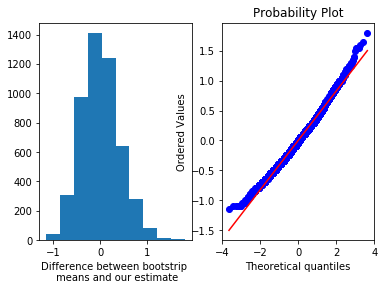

In [166]:
def generate_boots(sample_sml, num_boots=5000):
    #Generate samples with replacement from our sample
    boots = [np.random.choice(sample_sml, size=(samp_size_sml,)) for index in range(num_boots)]
    return boots

boots = generate_boots(sample_sml)

#Best estimate for the mean
lam_hat = np.mean(sample_sml)

#Best practive: Centre the samples with our estimate for the mean
boot_means = [np.mean(bs) - lam_hat for bs in boots]

fig_bs, ax_bs = plt.subplots(1, 2)
ax_bs[0].set_xlabel('Difference between bootstrip \n means and our estimate')
ax_bs[1].set_ylabel('Frequency')
ax_bs[0].hist(boot_means)
boot_qplot = probplot(boot_means, plot=ax_bs[1])
plt.show()

The q-plot shows that the difference between the bootstrap means and our estimate of the population mean is not particularly normally distributed at all. We can now derive empirical confidence intervals for the mean.

In [167]:
#Generate a confidence interval
def get_confint(boot_means, conf=95):
    
    ci_up = 50 + 0.5*conf
    ci_dn = 50 - 0.5*conf

    del_up = np.percentile(boot_means, ci_up)
    del_dn = np.percentile(boot_means, ci_dn)

    lam_up = lam_hat - del_dn
    lam_dn = lam_hat - del_up

    #Catch cases where the lower confidence limit is impossible (i.e Poisson means < 0 aren't possible)
    if lam_dn < 0:
        lam_dn = 0
        
    return lam_up, lam_dn

lam_up, lam_dn = get_confint(boot_means)
print('A {}% confidence interval for lambda is [{}, {}]'.format(conf, lam_dn, lam_up))

A 95% confidence interval for lambda is [0.8999999999999999, 2.55]


Finally, show the confidence interval on the bootstrap distribution of the means.

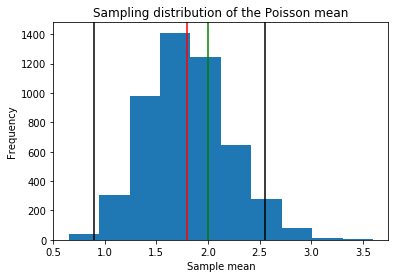

In [168]:
fig_lam, ax_lam = plt.subplots()
ax_lam.hist([np.mean(bs) for bs in boots])
ax_lam.axvline(lam_dn, c='black')
ax_lam.axvline(lam_hat, c='red')
ax_lam.axvline(lam, c='green')
ax_lam.axvline(lam_up, c='black')
ax_lam.set_xlabel('Sample mean')
ax_lam.set_ylabel('Frequency')
ax_lam.set_title('Sampling distribution of the Poisson mean')
plt.show()


Check what happens as we increase the number of bootstrap samples:

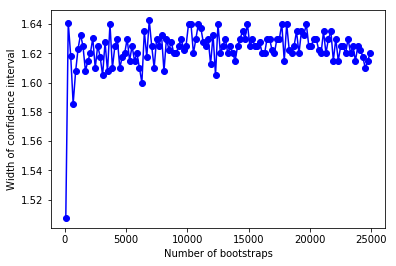

In [174]:
boot_sizes = np.arange(100, 25000, 200)

widths = []
for b in boot_sizes:
    reps = []
    
    #Stabilise the confidence interval by drawing 10 repeat bootstraps at each size, then take the mean
    for r in range(10):
        samples = generate_boots(sample_sml, num_boots=b)
        samples = [np.mean(s) - lam_hat for s in samples]
        lam_up, lam_dn = get_confint(samples)
        reps.extend([lam_up - lam_dn])
    widths.extend([np.mean(reps)])
    
fig_w, ax_w = plt.subplots()
ax_w.plot(boot_sizes, widths, 'bo-')
ax_w.set_xlabel('Number of bootstraps')
ax_w.set_ylabel('Width of confidence interval')
plt.show()

It seems that as the bootstrap size grows, the confidence interval stabilises, although after around 20000 samples there looks to be the beginning of a downward trend